# booking classifier

Allen Majewski 2018

# results:

```
(1)
model: naive bayes
features: whether fare<predicted_fare, fare - predicted_fare difference, class, carrier, Npassengers
training set size: 70424
test set size: 70424
accuracy: 0.888830512325
```

```
(2)
model: naive bayes
features: whether fare<predicted_fare, fare - predicted_fare difference, class, carrier, Npassengers
training set size: 211618
test set size: 211618
accuracy:	0.9595261272670567
```

More detailed features about the user sessions, such as the depth of the user's search (how many queries already) would improve the model.

It would be fruitful to run the classifier on the subset of booked flights.  I have run out of time however. 


# Introduction

We will try to predict whether a flight is ultimately bought.

Ideally, I'd like to consider:

### most important features
* the difference between the fare regression model's predicted fare and the actual fare
* whether the presented fare is cheaper than the predicted fare (1, or 0)
* the number of itineraries presented to the user in search (not implemented)
* the number of times the user has already searched in the session (people get tired) (not implemented)
* timedelta between search and takeoff
* type of OS of user (not implemented)
* the class - I figure business class ticket buyers are less picky
* the airline

### perhaps less important features
* absolute fare price
* other features we have lying around from the previous model

I did not implement all of the above due to time constaints. 

# methods

For this task, I made use of the difference between the fare predicted by my regression model and the actual fare.  To do this, I updated the dataframes with attributes ```predicted_fare, fare_diff, is_cheap```.

* ```predicted_fare``` is the regression model's predicted fare price
* ```fare_diff``` is the difference between the actual fare and the ```predicted_fare```
* ```is_cheap``` is 1 if ```predicted_fare > fare``` else 0

The text below details my preprocessing steps and the models I constructed.

## finding intersection of searched and booked flights

Below I'll modify the search_data DataFrame to include a was_booked column, with a 1 entry if the uid is found in the book_data set, and a 0 if not.

In [1]:
import pandas as pd
import numpy as np

print('loading df\'s')
bd = pd.DataFrame.from_csv('booking_data.csv')
ad = pd.DataFrame.from_csv('airport_data.csv')
sd = pd.DataFrame.from_csv('search_data.csv')

print('getting intersection of searched and booked')
was_booked = np.array(list(map(int, np.zeros(len(sd)))))
buids = { uid for uid in bd.booking_user_id }
suids = { uid for uid in sd.search_user_id }
searched_and_booked = suids & buids

print('assigning 1 to sd.was_booked')
n=0
for i, row in sd.iterrows():
    if row.search_user_id in searched_and_booked:
        was_booked[n] = 1
    n+=1
    
sd['was_booked'] = was_booked
print(len(sd[sd.was_booked == 1]))
sd.to_pickle('./sd_with_was_booked.pkl')

loading df's


/Users/altoidnerd/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2802: DtypeWarning: Columns (24) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


getting intersection of searched and booked
assigning 1 to sd.was_booked
18203


### read df pickle if needed

In [1]:
import pandas as pd
sd = pd.read_pickle('./sd_with_was_booked.pkl')

## use regression model to get predicted_fare - actual_fare


Then we can make use of the model presented in fare_regression.ipynb applied to the other half of the search data set.

#### train on small USD subset of search_data


First let's train it as we did before, on the smaller USD subset (just for testing, I'm having memory requirement issues). Then we can run the model to predict the fairs of the whole USD subset of the sd DataFrame.


(140848, 25)
getting airports
getting time deltas
getting classes
getting carriers
getting day of week 1
getting day of week 2
getting day of year
140848 140848
building fesatures n = 140800
training set size: 120424
test set size: 20424


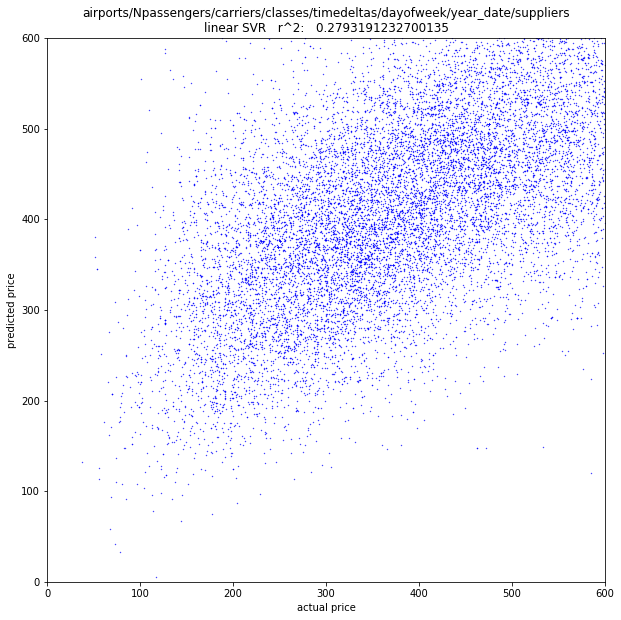

In [8]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import dateutil
import datetime
from sklearn import svm
from sklearn.metrics import r2_score
import gc

#
# uncomment if sd not defined
#
# sd = pd.read_pickle('./sd_with_was_booked.pkl')
#
df = pd.read_pickle('./sd_with_was_booked.pkl')
df = df.head(300000)
df = df[df.currency == 'USD']
df = df[df.fare < 20000 ]
print(df.shape)

gc.collect()

#
#  generte the hard lists needed in model
#


print('getting airports')
airports = set()
for i, row in df.iterrows():
    airports.add(row.origin)
    airports.add(row.destination)
airports = list(airports)
 
print('getting time deltas')
parse = dateutil.parser.parse

search_times = [ parse(time) for time in df.search_time ]
travel_times = [ ]
for i, row in df.iterrows():
    travel_times.append( parse(row.departure_datetime_1.split(';')[0]))

time_deltas = []
# append nan if the timestamps cannot be subtracted due to
# timezone not being supplied in one of the timestamps
for i, _ in enumerate(search_times):
    try:
        time_deltas.append(travel_times[i] - search_times[i])
    except TypeError:
        time_deltas.append('nan')

time_delta_days = [ ]
for delta in time_deltas:
    if delta == 'nan':
        time_delta_days.append('nan')
    else:
        time_delta_days.append(delta.days)
# impune mean values for 'nan' deltas
non_nans = [ thing for thing in time_delta_days if thing is not 'nan' ]
mean_value = np.mean(non_nans)
for i, val in enumerate(time_delta_days):
    if val is 'nan':
        time_delta_days[i] = mean_value
    
print('getting classes')
classes = list({ clas for clas in df.cabin_class })
#print(classes)

print('getting carriers')
carriers = ''
for carrier in df.carrier_1:
    carriers = str(carrier)+'; '
for carrier in df.carrier_2:
    carriers += str(carrier)+'; '
carriers = list(set(carriers.split('; ')))
#carriers.extend(['BG','IX','WY','ZI','TZ','IZ','SJ','3S','TO','D8','SE','DE'])
#print(carriers)


print('getting day of week 1')
departure_times_1 = travel_times
#for i, row in df.iterrows():
#    departure_times_1.append( parse(row.departure_datetime_1.split(';')[0]))
departure_weekdays_1 = [ date.weekday() for date in departure_times_1 ]

print('getting day of week 2')
departure_times_2 = [ ]
n=0
for i, row in df.iterrows():
    try:
        departure_times_2.append( parse(row.departure_datetime_2.split(';')[0]))
    except AttributeError:
        departure_times_2.append( departure_times_1[n])
    n+=1
departure_weekdays_2 = [ date.weekday() for date in departure_times_2 ]

print('getting day of year')
dep_day_of_year_1 = [ date.timetuple().tm_yday for date in departure_times_1 ]
dep_day_of_year_2 = [ date.timetuple().tm_yday for date in departure_times_2 ]
print(len(dep_day_of_year_1), len(dep_day_of_year_2))

suppliers = list({ supplier for supplier in df.supplier })
suppliers.sort()



#
# create the model 
#


X = []
n=-1
for i, row in df.iterrows():
    #print(n)
    n+=1
    if n%100==0:
        sys.stdout.write("building fesatures n = {}\r".format(n))
    # vectorize airport data 
    features = list(np.zeros(len(airports)))
    origin, destination = row.origin, row.destination
    features[airports.index(origin)] = 1
    features[airports.index(destination)] = 1
    
    # add number of passengers to features
    features.append(row.passengers)
    
    # do carriers
    # buggy stuff ... some carriers missing
    # from carriers list
    carr_features = list(np.zeros(len(carriers)))
    carrier_1 = str(row.carrier_1).split(';')
    carrier_2 = str(row.carrier_2).split(';')
    for carrier in carrier_1:
        try: 
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    for carrier in carrier_2:
        try:
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    features = features + carr_features
    
    # do classes
    class_features = list(np.zeros(len(airports)))
    cabin_class = row.cabin_class
    class_features[classes.index(cabin_class)] = 1 
    features = features + class_features 
    
    # add in the time delta between booking and travel (in days)
    features.append(time_delta_days[n])

    
    # add in the weekday feature
    weekday_features = list(np.zeros(7))
    weekday_features[departure_weekdays_1[n]] += 1
    weekday_features[departure_weekdays_2[n]] += 1
    features = features + weekday_features
    
    # add in the ordinal day of the year
    date_feature = list(np.zeros(366))
    date_feature[dep_day_of_year_1[n]] += 1
    date_feature[dep_day_of_year_2[n]] += 1
    features = features + date_feature
    
    
    # add in supplier feature
    supp_features = list(np.zeros(len(suppliers)))
    supp_features[suppliers.index(row.supplier)] = 1
    festures = features + supp_features
    
    # collect all features
    all_features = np.array(features)
    X.append(all_features)

# use half the dataset+50000 samples 
# to train, the rest to test

n_train=len(X)//2+50000
X_train = X[:n_train]
X_test  = X[n_train:]
print('\ntraining set size:', len(X_train))
print('test set size:', len(X_test))

# get fares which we intend to predict

y = []
for fare in df.fare:
    y.append(fare)

y_train = y[:n_train]
y_test  = y[n_train:]

model = svm.LinearSVR()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

#print("r^2:\t{}".format(r2_score(y_test, y_predict)))

plt.scatter(y_test, y_predict, marker='.', s=0.5, color='b')
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('airports/Npassengers/carriers/classes/timedeltas/dayofweek/year_date/suppliers\nlinear SVR   r^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()







### predict fares on USD subset of search_data

Now we run the model on the same subset of sd.

Loading df
(140848, 25)
getting airports
getting time deltas
getting classes
getting carriers
getting day of week 1
getting day of week 2
getting day of year
140848 140848
building fesatures n = 140800
training set size: 0
test set size: 140848


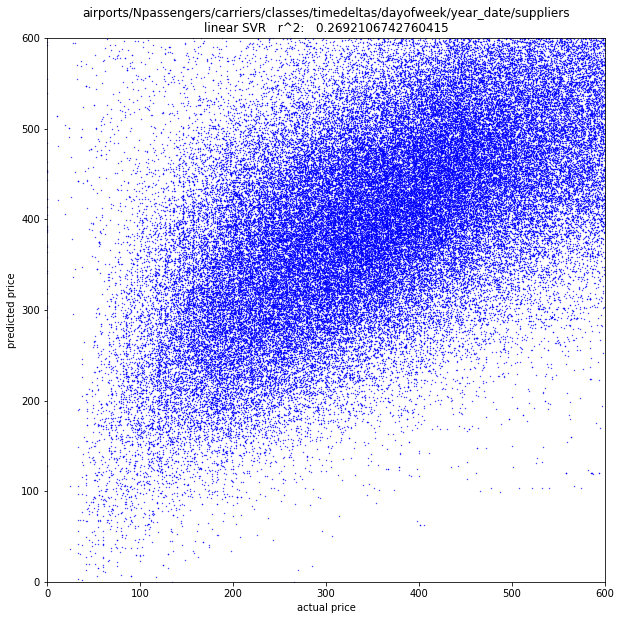

In [9]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import dateutil
import datetime
from sklearn import svm
from sklearn.metrics import r2_score
import gc


X = []
X_train = []
X_test = []
y = []
y_train = []
y_test   = []
time_delta_days = [] 
time_deltas = []
travel_times = []
dep_day_of_year_1 = []
dep_day_of_year_2 = []
departure_times_1 = []
departure_times_2 = []
departure_weekdays_1 = []
departure_weekdays_2 = []
n_train = 0


gc.collect()


print('Loading df')
#df = pd.read_pickle('./sd_with_was_booked.pkl')
#df = df.head(300000)
#df = df[df.currency == 'USD']
#df = df[df.fare < 20000 ]
print(df.shape)

#
#  generte the hard lists needed in model
#

gc.collect()


print('getting airports')
airports = set()
for i, row in df.iterrows():
    airports.add(row.origin)
    airports.add(row.destination)
airports = list(airports)
 
print('getting time deltas')
parse = dateutil.parser.parse

search_times = [ parse(time) for time in df.search_time ]
travel_times = [ ]
for i, row in df.iterrows():
    travel_times.append( parse(row.departure_datetime_1.split(';')[0]))

time_deltas = []
# append nan if the timestamps cannot be subtracted due to
# timezone not being supplied in one of the timestamps
for i, _ in enumerate(search_times):
    try:
        time_deltas.append(travel_times[i] - search_times[i])
    except TypeError:
        time_deltas.append('nan')

time_delta_days = [ ]
for delta in time_deltas:
    if delta == 'nan':
        time_delta_days.append('nan')
    else:
        time_delta_days.append(delta.days)
# impune mean values for 'nan' deltas
non_nans = [ thing for thing in time_delta_days if thing is not 'nan' ]
mean_value = np.mean(non_nans)
for i, val in enumerate(time_delta_days):
    if val is 'nan':
        time_delta_days[i] = mean_value
    
print('getting classes')
classes = list({ clas for clas in df.cabin_class })
#print(classes)

print('getting carriers')
carriers = ''
for carrier in df.carrier_1:
    carriers = str(carrier)+'; '
for carrier in df.carrier_2:
    carriers += str(carrier)+'; '
carriers = list(set(carriers.split('; ')))
#carriers.extend(['BG','IX','WY','ZI','TZ','IZ','SJ','3S','TO','D8','SE','DE'])
#print(carriers)


print('getting day of week 1')
departure_times_1 = travel_times
#for i, row in df.iterrows():
#    departure_times_1.append( parse(row.departure_datetime_1.split(';')[0]))
departure_weekdays_1 = [ date.weekday() for date in departure_times_1 ]

print('getting day of week 2')
departure_times_2 = [ ]
n=0
for i, row in df.iterrows():
    try:
        departure_times_2.append( parse(row.departure_datetime_2.split(';')[0]))
    except AttributeError:
        departure_times_2.append( departure_times_1[n])
    n+=1
departure_weekdays_2 = [ date.weekday() for date in departure_times_2 ]

print('getting day of year')
dep_day_of_year_1 = [ date.timetuple().tm_yday for date in departure_times_1 ]
dep_day_of_year_2 = [ date.timetuple().tm_yday for date in departure_times_2 ]
print(len(dep_day_of_year_1), len(dep_day_of_year_2))

suppliers = list({ supplier for supplier in df.supplier })
suppliers.sort()



#
# create the model 
#


X = []
n=-1
for i, row in df.iterrows():
    #print(n)
    n+=1
    if n%100==0:
        sys.stdout.write("building fesatures n = {}\r".format(n))
    # vectorize airport data 
    features = list(np.zeros(len(airports)))
    origin, destination = row.origin, row.destination
    features[airports.index(origin)] = 1
    features[airports.index(destination)] = 1
    
    # add number of passengers to features
    features.append(row.passengers)
    
    # do carriers
    # buggy stuff ... some carriers missing
    # from carriers list
    carr_features = list(np.zeros(len(carriers)))
    carrier_1 = str(row.carrier_1).split(';')
    carrier_2 = str(row.carrier_2).split(';')
    for carrier in carrier_1:
        try: 
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    for carrier in carrier_2:
        try:
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    features = features + carr_features
    
    # do classes
    class_features = list(np.zeros(len(airports)))
    cabin_class = row.cabin_class
    class_features[classes.index(cabin_class)] = 1 
    features = features + class_features 
    
    # add in the time delta between booking and travel (in days)
    features.append(time_delta_days[n])

    
    # add in the weekday feature
    weekday_features = list(np.zeros(7))
    weekday_features[departure_weekdays_1[n]] += 1
    weekday_features[departure_weekdays_2[n]] += 1
    features = features + weekday_features
    
    # add in the ordinal day of the year
    date_feature = list(np.zeros(366))
    date_feature[dep_day_of_year_1[n]] += 1
    date_feature[dep_day_of_year_2[n]] += 1
    features = features + date_feature
    
    
    # add in supplier feature
    supp_features = list(np.zeros(len(suppliers)))
    supp_features[suppliers.index(row.supplier)] = 1
    festures = features + supp_features
    
    # collect all features
    all_features = np.array(features)
    X.append(all_features)

# use half the dataset+150000 samples 
# to train, the rest to test

#n_train=len(X)//2+150000
#X_train = X[:n_train]
X_test = X

print('\ntraining set size:', len(X_train))
print('test set size:', len(X_test))

# get fares which we intend to predict

y = []
for fare in df.fare:
    y.append(fare)

#y_train = y[:n_train]
#y_test  = y[n_train:]
y_test   = y

#model = svm.LinearSVR()
#model.fit(X_train, y_train)
y_predict = model.predict(X_test)

#print("r^2:\t{}".format(r2_score(y_test, y_predict)))

plt.scatter(y_test, y_predict, marker='.', s=0.5, color='b')
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('airports/Npassengers/carriers/classes/timedeltas/dayofweek/year_date/suppliers\nlinear SVR   r^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()




## create df with predicted_fare, fare_diff, is_cheap

I want to use as features whether the predicted fare is less than the presented fare, and the absolute difference between the two without having to run the model repeatedly.  So I'll pickle a DataFrame with these attributes.

In [32]:
predicted_fare = y_predict
fare = y
is_cheap = np.array(list(map(int, np.zeros(len(df)))))
fare_diff = np.array(list(map(int, np.zeros(len(df)))))

for i, fare in enumerate(y):
    if predicted_fare[i] > fare:
        is_cheap[i] = 1
    diff = y[i] - predicted_fare[i]
    fare_diff[i] = diff
    
df['predicted_fare'] = predicted_fare
df['fare_diff'] = fare_diff
df['is_cheap'] = is_cheap
df.to_pickle('./sd_head300k_USD_with_wasbooked_farediff_ischeap.pkl')


## create shuffled df

The booked flights were mostly at the head of the dataset so we should shuffle them.

In [ ]:
df = df.sample(frac=1)
df.to_pickle('./sd_head300k_USD_with_wasbooked_farediff_ischeap_shuffled.pkl')

## read pickle if needed

In [21]:
import pandas as pd
df = pd.read_pickle('./sd_head300k_USD_with_wasbooked_farediff_ischeap_shuffled.pkl')

In [18]:
df

,search_time,currency,destination,search_user_id,language,origin,partner_id,passengers,pos,session_id,...,flight_num_2,departure_datetime_1,arrival_datetime_1,departure_datetime_2,arrival_datetime_2,itinerary_id,was_booked,predicted_fare,fare_diff,is_cheap
search_id,,,,,,,,,,,,,,,,,,,,,
04bd5825-53d7-41fc-8b6f-0a7bda80df64,2017-02-17 21:13:06,USD,NYC,fd3a4718261c1d6d4c0259db3ff49857,en,SJC,91,0,US,3dfa0ebb-b1d8-4e70-8e6b-039d47aaf433,...,AA1775; AA2489; AA6049,2017-04-29T07:55:00; 2017-04-29T12:30:00,2017-04-29T11:30:00; 2017-04-29T18:17:00,2017-05-06T13:00:00; 2017-05-06T18:50:00; 2017...,2017-05-06T18:07:00; 2017-05-06T20:16:00; 2017...,NaN,0,350.154406,-74,1
0141ba52-ddfa-4498-b8bd-d101a993923c,2017-02-18 01:15:36,USD,PRG,5cb598de0b8a70f8b584bf98c9e63ec5,en,JFK,91,2,US,c10bad96-e2db-408e-8c31-d62dcfbbada8,...,SU2015; SU100,2017-04-17T14:25:00; 2017-04-18T07:40:00,2017-04-18T06:25:00; 2017-04-18T09:25:00,2017-05-02T17:50:00; 2017-05-03T09:20:00,2017-05-02T21:25:00; 2017-05-03T12:05:00,NaN,0,598.832570,137,0
041d06ec-12f1-49ad-aa9f-22405ef7fb15,2017-02-18 10:46:23,USD,HBA,a89594623ae7d156aa9c81c63115c77c,en,TSV,91,5,US,55015e1a-95ca-4d19-8d32-92dfec7e0f6c,...,NaN,2017-02-25T06:05:00; 2017-02-25T08:55:00; 2017...,2017-02-25T08:00:00; 2017-02-25T12:15:00; 2017...,NaN,NaN,NaN,0,525.730174,-160,1
00f49c17-8687-4db4-9990-f3f654550097,2017-02-17 22:11:38,USD,BRU,9285779c4e77201288b581a245f2361c,en,SFO,91,1,US,2a6d1c05-0ec9-40d6-b743-5d61e20eed66,...,EI631; EI147,2017-08-12T22:20:00; 2017-08-14T06:15:00,2017-08-13T13:45:00; 2017-08-14T11:35:00,2017-08-20T10:10:00; 2017-08-20T12:30:00,2017-08-20T11:00:00; 2017-08-20T15:30:00,NaN,0,787.965506,625,0
00db603e-28bd-4c70-9d03-63ba2f48b09a,2017-02-18 14:25:44,USD,ORL,efeedebb3facd532a5ea0f2658100eda,en,ICT,91,6,US,4f13e7b2-e820-48bd-a3d7-9bb7f22d919a,...,UA725; UA3854,2017-05-27T15:00:00; 2017-05-27T17:40:00,2017-05-27T16:54:00; 2017-05-27T20:58:00,2017-06-02T06:00:00; 2017-06-02T09:10:00,2017-06-02T07:58:00; 2017-06-02T11:14:00,NaN,0,479.445021,-73,1
00194681-56e5-4d5e-a336-7039e8b7c507,2017-02-18 01:28:34,USD,AUS,aa0e407515b177a0a66ddd44605cfd34,en,MKE,91,2,US,1b2c7550-f290-40dd-9fda-7d8bdfde4f1f,...,AA2664; AA3120,2017-05-04T07:00:00; 2017-05-04T12:35:00,2017-05-04T09:44:00; 2017-05-04T13:36:00,2017-05-10T18:21:00; 2017-05-10T21:55:00,2017-05-10T21:07:00; 2017-05-10T22:36:00,NaN,0,356.953445,-27,1
01cc5383-2832-48dd-80c9-1dd41ea59a14,2017-02-17 22:38:05,USD,BOI,2c92272e798fddbbfd91bb6669d9ae7e,en,PHX,91,1,US,f9a9ed95-f97e-452d-9bc8-c1b585020b48,...,NaN,2017-03-08T06:21:00; 2017-03-08T10:40:00,2017-03-08T07:34:00; 2017-03-08T13:28:00,NaN,NaN,NaN,0,270.195355,-115,1
a03e26e6-8e5f-40b4-b644-858561af36e6,2017-02-01 05:19:26,USD,VPS,5bc7b75e-3a2a-4858-87f3-ce55adb3e748,en,PIT,91,2,US,7133b537-710a-4a60-977e-86b02aaaddcc,...,AA5384; AA5379,2017-03-18T13:59:00; 2017-03-18T16:40:00,2017-03-18T15:32:00; 2017-03-18T17:30:00,2017-03-25T06:00:00; 2017-03-25T09:50:00,2017-03-25T08:36:00; 2017-03-25T11:24:00,347bcc4c-064d-426e-b294-edde3687201f,1,561.351120,-113,1
05864440-f461-476a-af7f-c1dbd6d8f4f5,2017-02-18 07:06:58,USD,HNL,955ad9fe261852f91e2cbb228f1c4950,en,BOI,91,1,US,ad95149f-7af4-4204-ab4f-8d9c5af80902,...,UA72; UA1688; AS3444,2017-07-27T06:00:00; 2017-07-27T08:30:00,2017-07-27T06:18:00; 2017-07-27T11:30:00,2017-07-31T07:00:00; 2017-07-31T17:30:00; 2017...,2017-07-31T15:04:00; 2017-07-31T19:36:00; 2017...,NaN,0,931.127750,-272,1


# Naive Bayes model with fare difference, is_cheap

Let's construct a Naive Bayes classifier with only fare difference and is_cheap, time deltas, class.

In [23]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import dateutil
import datetime
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score
import gc

#
# uncomment if sd,df not defined
#
# sd = pd.read_pickle('./sd_with_was_booked.pkl')
#
#df = pd.read_pickle('./sd_with_was_booked.pkl')
#df = df.head(300000)
#df = df[df.currency == 'USD']
#df = df[df.fare < 20000 ]
df = pd.read_pickle('./sd_head300k_USD_with_wasbooked_farediff_ischeap_shuffled.pkl')
print(df.shape)





gc.collect()

#
#  generte the hard lists needed in model
#


#print('getting airports')
#airports = set()
#for i, row in df.iterrows():
#    airports.add(row.origin)
#    airports.add(row.destination)
#airports = list(airports)
 
print('getting time deltas')
parse = dateutil.parser.parse

search_times = [ parse(time) for time in df.search_time ]
travel_times = [ ]
for i, row in df.iterrows():
    travel_times.append( parse(row.departure_datetime_1.split(';')[0]))

time_deltas = []
# append nan if the timestamps cannot be subtracted due to
# timezone not being supplied in one of the timestamps
for i, _ in enumerate(search_times):
    try:
        time_deltas.append(travel_times[i] - search_times[i])
    except TypeError:
        time_deltas.append('nan')

time_delta_days = [ ]
for delta in time_deltas:
    if delta == 'nan':
        time_delta_days.append('nan')
    else:
        time_delta_days.append(delta.days)
# impune mean values for 'nan' deltas
non_nans = [ thing for thing in time_delta_days if thing is not 'nan' ]
mean_value = np.mean(non_nans)
for i, val in enumerate(time_delta_days):
    if val is 'nan':
        time_delta_days[i] = mean_value
    
print('getting classes')
classes = list({ clas for clas in df.cabin_class })
#print(classes)

print('getting carriers')
carriers = ''
for carrier in df.carrier_1:
    carriers = str(carrier)+'; '
for carrier in df.carrier_2:
    carriers += str(carrier)+'; '
carriers = list(set(carriers.split('; ')))


#print('getting day of week 1')
#departure_times_1 = travel_times
#for i, row in df.iterrows():
#    departure_times_1.append( parse(row.departure_datetime_1.split(';')[0]))
#departure_weekdays_1 = [ date.weekday() for date in departure_times_1 ]

#print('getting day of week 2')
#departure_times_2 = [ ]
#n=0
#for i, row in df.iterrows():
#    try:
#        departure_times_2.append( parse(row.departure_datetime_2.split(';')[0]))
#    except AttributeError:
#        departure_times_2.append( departure_times_1[n])
#    n+=1
#departure_weekdays_2 = [ date.weekday() for date in departure_times_2 ]

#print('getting day of year')
#dep_day_of_year_1 = [ date.timetuple().tm_yday for date in departure_times_1 ]
#dep_day_of_year_2 = [ date.timetuple().tm_yday for date in departure_times_2 ]
#print(len(dep_day_of_year_1), len(dep_day_of_year_2))

#suppliers = list({ supplier for supplier in df.supplier })
#suppliers.sort()



#
# create the model 
#


X = []
n=-1
for i, row in df.iterrows():
    #print(n)
    n+=1
    if n%100==0:
        sys.stdout.write("building fesatures n = {}\r".format(n))
    # vectorize airport data 
    #features = list(np.zeros(len(airports)))
    features = []
    #origin, destination = row.origin, row.destination
    #features[airports.index(origin)] = 1
    #features[airports.index(destination)] = 1
    
    # add number of passengers to features
    features.append(row.passengers)
    
    # do carriers
    # buggy stuff ... some carriers missing
    # from carriers list
    #carr_features = list(np.zeros(len(carriers)))
    #carrier_1 = str(row.carrier_1).split(';')
    #carrier_2 = str(row.carrier_2).split(';')
    #for carrier in carrier_1:
    #    try: 
    #        carr_features[carriers.index(carrier.strip())] = 1
    #    except ValueError:
    #        carr_features[carriers.index('nan')] = 1
    #for carrier in carrier_2:
    #    try:
    #        carr_features[carriers.index(carrier.strip())] = 1
    #    except ValueError:
   #         carr_features[carriers.index('nan')] = 1
   # features = features + carr_features
    
    # do classes
    class_features = list(np.zeros(len(classes)))
    cabin_class = row.cabin_class
    class_features[classes.index(cabin_class)] = 1 
    features = features + class_features 
    
    # add in the time delta between booking and travel (in days)
    features.append(time_delta_days[n])

    
    # add in the weekday feature
    #weekday_features = list(np.zeros(7))
    #weekday_features[departure_weekdays_1[n]] += 1
    #weekday_features[departure_weekdays_2[n]] += 1
    #features = features + weekday_features
    
    # add in the ordinal day of the year
    #date_feature = list(np.zeros(366))
    #date_feature[dep_day_of_year_1[n]] += 1
    #date_feature[dep_day_of_year_2[n]] += 1
    #features = features + date_feature
    
    
    # add in supplier feature
    #supp_features = list(np.zeros(len(suppliers)))
    #supp_features[suppliers.index(row.supplier)] = 1
    #festures = features + supp_features
    
    # collect all features
    
    # add fare, farediff, is_cheap
    features.append(row.fare)
    features.append(row.fare_diff)
    features.append(row.is_cheap)
    
    all_features = np.array(features)
    X.append(all_features)

# use half the dataset+50000 samples 
# to train, the rest to test

n_train=len(X)//2
X_train = X[:n_train]
X_test  = X[n_train:]
print('\ntraining set size:', len(X_train))
print('test set size:', len(X_test))

# get was_booked attribute which we intend to predict

y = []
for booked in df.was_booked:
    y.append(booked)

y_train = y[:n_train]
y_test  = y[n_train:]

model = naive_bayes.GaussianNB()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print(accuracy_score(y_test, y_predict))

#print("r^2:\t{}".format(r2_score(y_test, y_predict)))

#plt.scatter(y_test, y_predict, marker='.', s=0.5, color='b')
#plt.xlim(0,600)
#plt.ylim(0,600)
#plt.title('airports/Npassengers/carriers/classes/timedeltas/dayofweek/year_date/suppliers\nlinear SVR   r^2:   {}'.format(r2_score(y_test, y_predict)))
#plt.ylabel('predicted price')
#plt.xlabel('actual price')
#fig = plt.gcf()
#fig.set_size_inches(10,10)
#plt.show()




(140848, 28)
getting time deltas
getting classes
getting carriers
building fesatures n = 140800
training set size: 70424
test set size: 70424
0.888830512325


# trying a bigger subset

Start over with fare prediction.

(423236, 25)
getting airports
getting time deltas
getting classes
getting carriers
getting day of week 1
getting day of week 2
getting day of year
423236 423236
building fesatures n = 423200
training set size: 261618
test set size: 161618


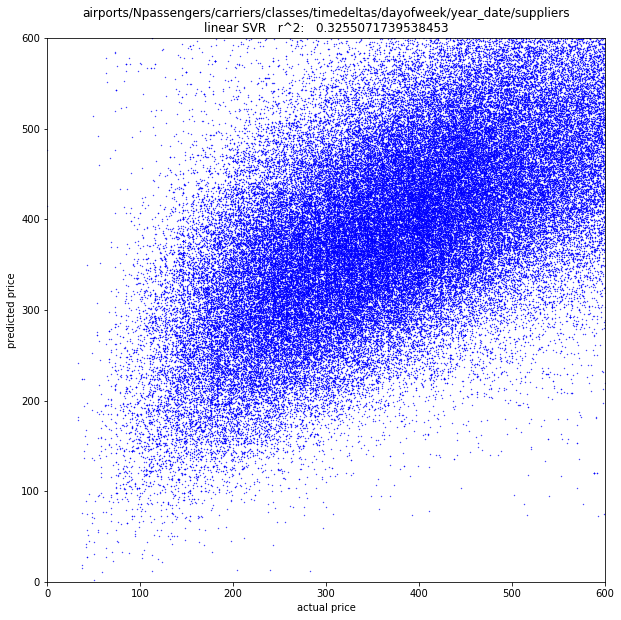

In [2]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import dateutil
import datetime
from sklearn import svm
from sklearn.metrics import r2_score
import gc

#
# uncomment if sd not defined
#
# sd = pd.read_pickle('./sd_with_was_booked.pkl')
#
df = pd.read_pickle('./sd_with_was_booked.pkl')
df = df.head(600000)
df = df[df.currency == 'USD']
df = df[df.fare < 20000 ]
print(df.shape)

gc.collect()

#
#  generte the hard lists needed in model
#


print('getting airports')
airports = set()
for i, row in df.iterrows():
    airports.add(row.origin)
    airports.add(row.destination)
airports = list(airports)
 
print('getting time deltas')
parse = dateutil.parser.parse

search_times = [ parse(time) for time in df.search_time ]
travel_times = [ ]
for i, row in df.iterrows():
    travel_times.append( parse(row.departure_datetime_1.split(';')[0]))

time_deltas = []
# append nan if the timestamps cannot be subtracted due to
# timezone not being supplied in one of the timestamps
for i, _ in enumerate(search_times):
    try:
        time_deltas.append(travel_times[i] - search_times[i])
    except TypeError:
        time_deltas.append('nan')

time_delta_days = [ ]
for delta in time_deltas:
    if delta == 'nan':
        time_delta_days.append('nan')
    else:
        time_delta_days.append(delta.days)
# impune mean values for 'nan' deltas
non_nans = [ thing for thing in time_delta_days if thing is not 'nan' ]
mean_value = np.mean(non_nans)
for i, val in enumerate(time_delta_days):
    if val is 'nan':
        time_delta_days[i] = mean_value
    
print('getting classes')
classes = list({ clas for clas in df.cabin_class })
#print(classes)

print('getting carriers')
carriers = ''
for carrier in df.carrier_1:
    carriers = str(carrier)+'; '
for carrier in df.carrier_2:
    carriers += str(carrier)+'; '
carriers = list(set(carriers.split('; ')))
#carriers.extend(['BG','IX','WY','ZI','TZ','IZ','SJ','3S','TO','D8','SE','DE'])
#print(carriers)


print('getting day of week 1')
departure_times_1 = travel_times
#for i, row in df.iterrows():
#    departure_times_1.append( parse(row.departure_datetime_1.split(';')[0]))
departure_weekdays_1 = [ date.weekday() for date in departure_times_1 ]

print('getting day of week 2')
departure_times_2 = [ ]
n=0
for i, row in df.iterrows():
    try:
        departure_times_2.append( parse(row.departure_datetime_2.split(';')[0]))
    except AttributeError:
        departure_times_2.append( departure_times_1[n])
    n+=1
departure_weekdays_2 = [ date.weekday() for date in departure_times_2 ]

print('getting day of year')
dep_day_of_year_1 = [ date.timetuple().tm_yday for date in departure_times_1 ]
dep_day_of_year_2 = [ date.timetuple().tm_yday for date in departure_times_2 ]
print(len(dep_day_of_year_1), len(dep_day_of_year_2))

suppliers = list({ supplier for supplier in df.supplier })
suppliers.sort()



#
# create the model 
#


X = []
n=-1
for i, row in df.iterrows():
    #print(n)
    n+=1
    if n%100==0:
        sys.stdout.write("building fesatures n = {}\r".format(n))
    # vectorize airport data 
    features = list(np.zeros(len(airports)))
    origin, destination = row.origin, row.destination
    features[airports.index(origin)] = 1
    features[airports.index(destination)] = 1
    
    # add number of passengers to features
    features.append(row.passengers)
    
    # do carriers
    # buggy stuff ... some carriers missing
    # from carriers list
    carr_features = list(np.zeros(len(carriers)))
    carrier_1 = str(row.carrier_1).split(';')
    carrier_2 = str(row.carrier_2).split(';')
    for carrier in carrier_1:
        try: 
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    for carrier in carrier_2:
        try:
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    features = features + carr_features
    
    # do classes
    class_features = list(np.zeros(len(classes)))
    cabin_class = row.cabin_class
    class_features[classes.index(cabin_class)] = 1 
    features = features + class_features 
    
    # add in the time delta between booking and travel (in days)
    features.append(time_delta_days[n])

    
    # add in the weekday feature
    weekday_features = list(np.zeros(7))
    weekday_features[departure_weekdays_1[n]] += 1
    weekday_features[departure_weekdays_2[n]] += 1
    features = features + weekday_features
    
    # add in the ordinal day of the year
    date_feature = list(np.zeros(366))
    date_feature[dep_day_of_year_1[n]] += 1
    date_feature[dep_day_of_year_2[n]] += 1
    features = features + date_feature
    
    
    # add in supplier feature
    supp_features = list(np.zeros(len(suppliers)))
    supp_features[suppliers.index(row.supplier)] = 1
    festures = features + supp_features
    
    # collect all features
    all_features = np.array(features)
    X.append(all_features)

# use half the dataset+50000 samples 
# to train, the rest to test

n_train=len(X)//2+50000
X_train = X[:n_train]
X_test  = X[n_train:]
print('\ntraining set size:', len(X_train))
print('test set size:', len(X_test))

# get fares which we intend to predict

y = []
for fare in df.fare:
    y.append(fare)

y_train = y[:n_train]
y_test  = y[n_train:]

model = svm.LinearSVR()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

#print("r^2:\t{}".format(r2_score(y_test, y_predict)))

plt.scatter(y_test, y_predict, marker='.', s=0.5, color='b')
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('airports/Npassengers/carriers/classes/timedeltas/dayofweek/year_date/suppliers\nlinear SVR   r^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()





## now predict on that subset

(423236, 25)
getting airports
getting time deltas
getting classes
getting carriers
getting day of week 1
getting day of week 2
getting day of year
423236 423236
building fesatures n = 423200
training set size: 0
test set size: 423236


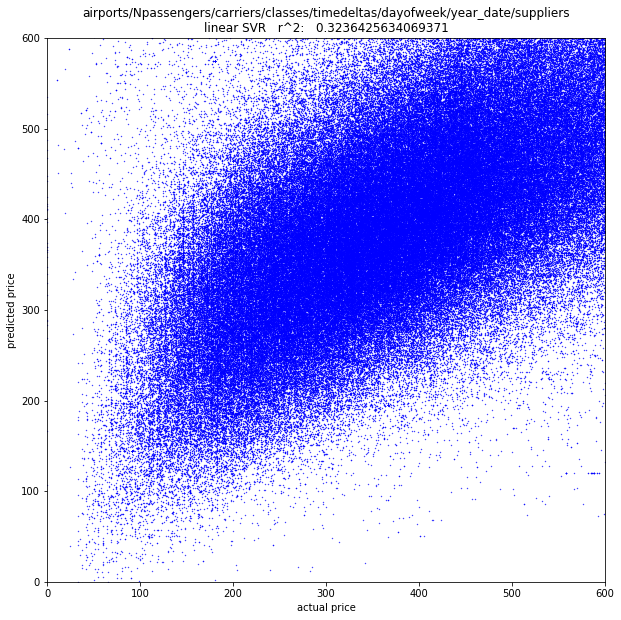

In [3]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import dateutil
import datetime
from sklearn import svm
from sklearn.metrics import r2_score
import gc


X = []
X_train = []
X_test = []
y = []
y_train = []
y_test   = []
time_delta_days = [] 
time_deltas = []
travel_times = []
dep_day_of_year_1 = []
dep_day_of_year_2 = []
departure_times_1 = []
departure_times_2 = []
departure_weekdays_1 = []
departure_weekdays_2 = []
n_train = 0


gc.collect()


#print('Loading df')
#df = pd.read_pickle('./sd_with_was_booked.pkl')
#df = df.head(600000)
#df = df[df.currency == 'USD']
#df = df[df.fare < 20000 ]
print(df.shape)

#
#  generte the hard lists needed in model
#

gc.collect()


print('getting airports')
airports = set()
for i, row in df.iterrows():
    airports.add(row.origin)
    airports.add(row.destination)
airports = list(airports)
 
print('getting time deltas')
parse = dateutil.parser.parse

search_times = [ parse(time) for time in df.search_time ]
travel_times = [ ]
for i, row in df.iterrows():
    travel_times.append( parse(row.departure_datetime_1.split(';')[0]))

time_deltas = []
# append nan if the timestamps cannot be subtracted due to
# timezone not being supplied in one of the timestamps
for i, _ in enumerate(search_times):
    try:
        time_deltas.append(travel_times[i] - search_times[i])
    except TypeError:
        time_deltas.append('nan')

time_delta_days = [ ]
for delta in time_deltas:
    if delta == 'nan':
        time_delta_days.append('nan')
    else:
        time_delta_days.append(delta.days)
# impune mean values for 'nan' deltas
non_nans = [ thing for thing in time_delta_days if thing is not 'nan' ]
mean_value = np.mean(non_nans)
for i, val in enumerate(time_delta_days):
    if val is 'nan':
        time_delta_days[i] = mean_value
    
print('getting classes')
classes = list({ clas for clas in df.cabin_class })
#print(classes)

print('getting carriers')
carriers = ''
for carrier in df.carrier_1:
    carriers = str(carrier)+'; '
for carrier in df.carrier_2:
    carriers += str(carrier)+'; '
carriers = list(set(carriers.split('; ')))
#carriers.extend(['BG','IX','WY','ZI','TZ','IZ','SJ','3S','TO','D8','SE','DE'])
#print(carriers)


print('getting day of week 1')
departure_times_1 = travel_times
#for i, row in df.iterrows():
#    departure_times_1.append( parse(row.departure_datetime_1.split(';')[0]))
departure_weekdays_1 = [ date.weekday() for date in departure_times_1 ]

print('getting day of week 2')
departure_times_2 = [ ]
n=0
for i, row in df.iterrows():
    try:
        departure_times_2.append( parse(row.departure_datetime_2.split(';')[0]))
    except AttributeError:
        departure_times_2.append( departure_times_1[n])
    n+=1
departure_weekdays_2 = [ date.weekday() for date in departure_times_2 ]

print('getting day of year')
dep_day_of_year_1 = [ date.timetuple().tm_yday for date in departure_times_1 ]
dep_day_of_year_2 = [ date.timetuple().tm_yday for date in departure_times_2 ]
print(len(dep_day_of_year_1), len(dep_day_of_year_2))

suppliers = list({ supplier for supplier in df.supplier })
suppliers.sort()



#
# create the model 
#


X = []
n=-1
for i, row in df.iterrows():
    #print(n)
    n+=1
    if n%100==0:
        sys.stdout.write("building fesatures n = {}\r".format(n))
    # vectorize airport data 
    features = list(np.zeros(len(airports)))
    origin, destination = row.origin, row.destination
    features[airports.index(origin)] = 1
    features[airports.index(destination)] = 1
    
    # add number of passengers to features
    features.append(row.passengers)
    
    # do carriers
    # buggy stuff ... some carriers missing
    # from carriers list
    carr_features = list(np.zeros(len(carriers)))
    carrier_1 = str(row.carrier_1).split(';')
    carrier_2 = str(row.carrier_2).split(';')
    for carrier in carrier_1:
        try: 
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    for carrier in carrier_2:
        try:
            carr_features[carriers.index(carrier.strip())] = 1
        except ValueError:
            carr_features[carriers.index('nan')] = 1
    features = features + carr_features
    
    # do classes
    class_features = list(np.zeros(len(classes)))
    cabin_class = row.cabin_class
    class_features[classes.index(cabin_class)] = 1 
    features = features + class_features 
    
    # add in the time delta between booking and travel (in days)
    features.append(time_delta_days[n])

    
    # add in the weekday feature
    weekday_features = list(np.zeros(7))
    weekday_features[departure_weekdays_1[n]] += 1
    weekday_features[departure_weekdays_2[n]] += 1
    features = features + weekday_features
    
    # add in the ordinal day of the year
    date_feature = list(np.zeros(366))
    date_feature[dep_day_of_year_1[n]] += 1
    date_feature[dep_day_of_year_2[n]] += 1
    features = features + date_feature
    
    
    # add in supplier feature
    supp_features = list(np.zeros(len(suppliers)))
    supp_features[suppliers.index(row.supplier)] = 1
    festures = features + supp_features
    
    # collect all features
    all_features = np.array(features)
    X.append(all_features)

# use half the dataset+150000 samples 
# to train, the rest to test

#n_train=len(X)//2+150000
#X_train = X[:n_train]
X_test = X

print('\ntraining set size:', len(X_train))
print('test set size:', len(X_test))

# get fares which we intend to predict

y = []
for fare in df.fare:
    y.append(fare)

#y_train = y[:n_train]
#y_test  = y[n_train:]
y_test   = y

#model = svm.LinearSVR()
#model.fit(X_train, y_train)
y_predict = model.predict(X_test)

#print("r^2:\t{}".format(r2_score(y_test, y_predict)))

plt.scatter(y_test, y_predict, marker='.', s=0.5, color='b')
plt.xlim(0,600)
plt.ylim(0,600)
plt.title('airports/Npassengers/carriers/classes/timedeltas/dayofweek/year_date/suppliers\nlinear SVR   r^2:   {}'.format(r2_score(y_test, y_predict)))
plt.ylabel('predicted price')
plt.xlabel('actual price')
fig = plt.gcf()
fig.set_size_inches(10,10)
plt.show()





## make pickle, shuffled pickle

In [4]:
predicted_fare = y_predict
fare = y
is_cheap = np.array(list(map(int, np.zeros(len(df)))))
fare_diff = np.array(list(map(int, np.zeros(len(df)))))

for i, fare in enumerate(y):
    if predicted_fare[i] > fare:
        is_cheap[i] = 1
    diff = y[i] - predicted_fare[i]
    fare_diff[i] = diff
    
df['predicted_fare'] = predicted_fare
df['fare_diff'] = fare_diff
df['is_cheap'] = is_cheap
#
# uncomment the line below to store this dataframe 
#
df.to_pickle('./sd_head600k_USD_with_wasbooked_farediff_ischeap.pkl')
df=df.sample(frac=1)
df.to_pickle('./sd_head600k_USD_with_wasbooked_farediff_ischeap_shuffled.pkl')

## do naive bayes

In [25]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import dateutil
import datetime
from sklearn import naive_bayes
from sklearn.metrics import accuracy_score
import gc

#
# uncomment if sd,df not defined
#
# sd = pd.read_pickle('./sd_with_was_booked.pkl')
#
#df = pd.read_pickle('./sd_with_was_booked.pkl')
#df = df.head(300000)
#df = df[df.currency == 'USD']
#df = df[df.fare < 20000 ]

df = pd.read_pickle('./sd_head600k_USD_with_wasbooked_farediff_ischeap_shuffled.pkl')
print(df.shape)





gc.collect()

#
#  generte the hard lists needed in model
#


#print('getting airports')
#airports = set()
#for i, row in df.iterrows():
#    airports.add(row.origin)
#    airports.add(row.destination)
#airports = list(airports)
 
print('getting time deltas')
parse = dateutil.parser.parse

search_times = [ parse(time) for time in df.search_time ]
travel_times = [ ]
for i, row in df.iterrows():
    travel_times.append( parse(row.departure_datetime_1.split(';')[0]))

time_deltas = []
# append nan if the timestamps cannot be subtracted due to
# timezone not being supplied in one of the timestamps
for i, _ in enumerate(search_times):
    try:
        time_deltas.append(travel_times[i] - search_times[i])
    except TypeError:
        time_deltas.append('nan')

time_delta_days = [ ]
for delta in time_deltas:
    if delta == 'nan':
        time_delta_days.append('nan')
    else:
        time_delta_days.append(delta.days)
# impune mean values for 'nan' deltas
non_nans = [ thing for thing in time_delta_days if thing is not 'nan' ]
mean_value = np.mean(non_nans)
for i, val in enumerate(time_delta_days):
    if val is 'nan':
        time_delta_days[i] = mean_value
    
print('getting classes')
classes = list({ clas for clas in df.cabin_class })
#print(classes)

print('getting carriers')
carriers = ''
for carrier in df.carrier_1:
    carriers = str(carrier)+'; '
for carrier in df.carrier_2:
    carriers += str(carrier)+'; '
carriers = list(set(carriers.split('; ')))


#print('getting day of week 1')
#departure_times_1 = travel_times
#for i, row in df.iterrows():
#    departure_times_1.append( parse(row.departure_datetime_1.split(';')[0]))
#departure_weekdays_1 = [ date.weekday() for date in departure_times_1 ]

#print('getting day of week 2')
#departure_times_2 = [ ]
#n=0
#for i, row in df.iterrows():
#    try:
#        departure_times_2.append( parse(row.departure_datetime_2.split(';')[0]))
#    except AttributeError:
#        departure_times_2.append( departure_times_1[n])
#    n+=1
#departure_weekdays_2 = [ date.weekday() for date in departure_times_2 ]

#print('getting day of year')
#dep_day_of_year_1 = [ date.timetuple().tm_yday for date in departure_times_1 ]
#dep_day_of_year_2 = [ date.timetuple().tm_yday for date in departure_times_2 ]
#print(len(dep_day_of_year_1), len(dep_day_of_year_2))

#suppliers = list({ supplier for supplier in df.supplier })
#suppliers.sort()



#
# create the model 
#


X = []
n=-1
for i, row in df.iterrows():
    #print(n)
    n+=1
    if n%100==0:
        sys.stdout.write("building fesatures n = {}\r".format(n))
    # vectorize airport data 
    #features = list(np.zeros(len(airports)))
    features = []
    #origin, destination = row.origin, row.destination
    #features[airports.index(origin)] = 1
    #features[airports.index(destination)] = 1
    
    # add number of passengers to features
    features.append(row.passengers)
    
    # do carriers
    # buggy stuff ... some carriers missing
    # from carriers list
    #carr_features = list(np.zeros(len(carriers)))
    #carrier_1 = str(row.carrier_1).split(';')
    #carrier_2 = str(row.carrier_2).split(';')
    #for carrier in carrier_1:
    #    try: 
    #        carr_features[carriers.index(carrier.strip())] = 1
    #    except ValueError:
    #        carr_features[carriers.index('nan')] = 1
    #for carrier in carrier_2:
    #    try:
    #        carr_features[carriers.index(carrier.strip())] = 1
    #    except ValueError:
   #         carr_features[carriers.index('nan')] = 1
   # features = features + carr_features
    
    # do classes
    class_features = list(np.zeros(len(classes)))
    cabin_class = row.cabin_class
    class_features[classes.index(cabin_class)] = 1 
    features = features + class_features 
    
    # add in the time delta between booking and travel (in days)
    features.append(time_delta_days[n])

    
    # add in the weekday feature
    #weekday_features = list(np.zeros(7))
    #weekday_features[departure_weekdays_1[n]] += 1
    #weekday_features[departure_weekdays_2[n]] += 1
    #features = features + weekday_features
    
    # add in the ordinal day of the year
    #date_feature = list(np.zeros(366))
    #date_feature[dep_day_of_year_1[n]] += 1
    #date_feature[dep_day_of_year_2[n]] += 1
    #features = features + date_feature
    
    
    # add in supplier feature
    #supp_features = list(np.zeros(len(suppliers)))
    #supp_features[suppliers.index(row.supplier)] = 1
    #festures = features + supp_features
    
    # collect all features
    
    # add fare, farediff, is_cheap
    features.append(row.fare)
    features.append(row.fare_diff)
    features.append(row.is_cheap)
    
    all_features = np.array(features)
    X.append(all_features)

# use half the dataset+50000 samples 
# to train, the rest to test

n_train=len(X)//2
X_train = X[:n_train]
X_test  = X[n_train:]
print('\ntraining set size:', len(X_train))
print('test set size:', len(X_test))

# get was_booked attribute which we intend to predict

y = []
for booked in df.was_booked:
    y.append(booked)

y_train = y[:n_train]
y_test  = y[n_train:]

model = naive_bayes.GaussianNB()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print("accuracy:\t{}".format(accuracy_score(y_test, y_predict)))

#print("r^2:\t{}".format(r2_score(y_test, y_predict)))

#plt.scatter(y_test, y_predict, marker='.', s=0.5, color='b')
#plt.xlim(0,600)
#plt.ylim(0,600)
#plt.title('airports/Npassengers/carriers/classes/timedeltas/dayofweek/year_date/suppliers\nlinear SVR   r^2:   {}'.format(r2_score(y_test, y_predict)))
#plt.ylabel('predicted price')
#plt.xlabel('actual price')
#fig = plt.gcf()
#fig.set_size_inches(10,10)
#plt.show()





(423236, 28)
getting time deltas
getting classes
getting carriers
building fesatures n = 423200
training set size: 211618
test set size: 211618
accuracy:	0.9595261272670567
